# Udacity's Self-Driving Car Engineer Nanodegree: PID-Controller Project
This notebook accompanies Stephan Studener's solution to the PID-Controller project in Udacity's Self-Driving Car Engineer Nanodegree in January 2020. In this project, the goal is to implement a PID-Controller that controls the lateral dynamics of a car in a simulated environment. This notebook supports rapid tuning of the control parameters by applying closed loop simulation of a lane change to a low-order approximation of the full vehicle. 

In [25]:
import numpy as np
import matplotlib.pyplot as plt

## The kinematic bicycle model and numerical integration of the dynamical system
Francesco Borrelli et al. studied different kinematic and dynamic vehicle models for autonomous driving control design. The following picture is taken from their work https://borrelli.me.berkeley.edu/pdfpub/IV_KinematicMPC_jason.pdf. 

![Sketch of the bicycle model](sketch_bicycle_model.JPG)

The figure displays the kinematics of the vehicle model known as the "Bicycle"-Model. The following equations of motion hold for the positions (x and y), the heading angle (theta), the steering angle (rho) and the angle between the longitudinal axis of the vehcile and the velocity v of the center of mass (beta):

![Sketch of the bicycle model](equations_bicycle_model.JPG)

The following class implements the equations of motion together with an numerical integrator (1st-order or "Forward-Euler") that solves the differential equations over a given set of n timesteps of equal duration dt. The steering angle is taken to be the control input u and is assumed to be constant over the period of integration n times dt.

In [30]:
class Bicycle:
    def __init__(self, l_r = 1.738, l_f = 1.105, v_l = 0.0, x0=np.array([1.0,1.0,0.0])):
        """
        This is the constructor with processes the following parameters: 
        l_r, parameter, distance from COG
        l_f, parameter, distance from COG
        v_l, longitudinal velocity, in direction of vehicle main axis
        x0, initial state, position and heading of vehicle = [px py theta]
        """
        self.l_r = l_r # parameter, distance from COG
        self.l_f = l_f # parameter, distance from COG
        self.v_l = v_l # longitudinal velocity, in direction of longitudinal axis of the vehicle
        self.x = x0 # initial state, position and heading of vehicle = [px py theta]
        self.dt = 0.01 # time step for numerical integration
        self.u = 0 # steering ange
    
    def __beta(self):
        """
        Angle of current velocity of COG w.r.t. the longitudinal axis of the vehicle / w.r.t. v_l.
        The angle is constrained to [-25° 25°]!
        """
        if self.u > 25 * np.pi/180:
            self.u = 25 * np.pi/180
        
        if self.u < -25 * np.pi/180:
            self.u = -25 * np.pi / 180
        
        return np.arctan((self.l_r / (self.l_r + self.l_f)) * np.tan(self.u)) 
        
    def __dot_px(self):
        """
        Equations of motion of kinematic bike model for dot(px).    
        """
        beta = self.__beta()
        v = self.v_l / np.cos(beta) # current velocity of COG w.r.t. the longitudinal axis of the vehicle
        theta = self.x[2]
        return v * np.cos(theta + beta)
    
    def __dot_py(self):
        """
        Equations of motion of kinematic bike model for dot(py).        
        """
        beta = self.__beta()
        v = self.v_l / np.cos(beta) # current velocity of COG w.r.t. the longitudinal axis of the vehicle
        theta = self.x[2]
        return v * np.sin(theta + beta)
    
    def __dot_theta(self):
        """
        Equations of motion for heading theta.
        """
        beta = self.__beta()
        v = self.v_l / np.cos(beta) # current velocity of COG w.r.t. the longitudinal axis of the vehicle
        return v / self.l_r * np.sin(beta)
        
    
    def integrate(self, n = 1):
        """
        Integrates equations of motion over dt and updates the state vector x with processes the following parameters:
        n, the number of integration steps that are suppsed to be taken; note: u is constant over n * dt!
        """
        k = 0
        while k < n:
            dpx = self.__dot_px() * self.dt
            dpy = self.__dot_py() * self.dt
            dtheta = self.__dot_theta() * self.dt
            self.x = self.x + np.array([dpx,dpy,dtheta])
            k+=1

## Simulating a lane change with the bicycle model

The following helper function defines a reference trajectory for the y-coordinate. It represents a steep lane change excited at t = 10.0s.

In [31]:
def reference(t, mag = 3.0):
    """
    This function returns the reference trajectory; it accepts the following parameter:
    mag, the magnitude ot he lane change, default is 3.0 m.
    """
    if t < 10:
        r = 0
    else:
        r = mag * ((3/2) * np.exp(-2.5*(t-10)) - (1/2) * np.exp(-4.0*(t-10))) - mag
    
    return r

The following helper function wraps up numerical integration and control law implementation for the parameter optimization.

In [32]:
def run_closed_loop_simulation(vehicle, parameters, n=1000):
    """
    This function implements a run of the cloed loop system and returns the resulting x- and y-trajectories
    exicetd by the vehicle.
    It accepts the following parameters:
    vehicle, an instance of a bicylce model of the vehicle.
    parameters, the vector of parameters kp, kd and ki for the PID-Control-Law (in THAT order!).
    n, the number of integration steps
    """
    x = []
    y = []
    u = []
    t = []
    r = []
    x.append(vehicle.x[0])
    y.append(vehicle.x[1])
    u.append(vehicle.u)
    t.append(0.0)
    r.append(reference(0))
    kp = parameters[0]
    kd = parameters[1]
    ki = parameters[2]
    integrated_error = 0.0
    error = 0.0
    objective = 0.0
    for i in range(n-1):
        difference_error = reference(i * vehicle.dt) - vehicle.x[1] - error
        error = reference((i+1) * vehicle.dt) - vehicle.x[1]
        integrated_error = integrated_error + error
        vehicle.u = kp * error + kd * difference_error + ki * integrated_error
        vehicle.integrate()
        x.append(vehicle.x[0])
        y.append(vehicle.x[1])
        u.append(vehicle.u*180/np.pi)
        t.append((i+1) * vehicle.dt)
        r.append(reference(i * vehicle.dt))
        objective += error ** 2
        
    return x, y, u, r, t, objective / n

Now we use the dynamical model to study the performance of a PID-Control-law.
An instance of the bicycle is created with initial location (x0) and longitudinal velocity (not equal to the resulting velocity of the center of mass!). The task of the controller is to make the vehicle follow a reference trajectory as close as possible. The reference is given by the function reference defined in the cell above. The reference trajectory represents a sharp lane change at t = 10. 
In the following, an initial guess of PID-parameters is applied to an instance of the bicycle model that represents a Hyundai Azera (total wheel- base of 2.843 m, lf =1.105 m and lr = 1.738 m). The initial guess is wrapped up in the parameters array below.

Initially, the controller parameters below have been choosen intuitively, starting with integral gain set to zero and small proportional gain of 0.1. Within a few simulation runs, it was discovered, that increasing the differenital gain helps the controller to settle much smoother. Attention was paid to not exceed the steering angle limits of [-25° 25°]. Moreover, the gains are kept small to allow for model uncertainty (parameters of the model may not reflect the properties of the car in the simulator) in the simulator later in this work.

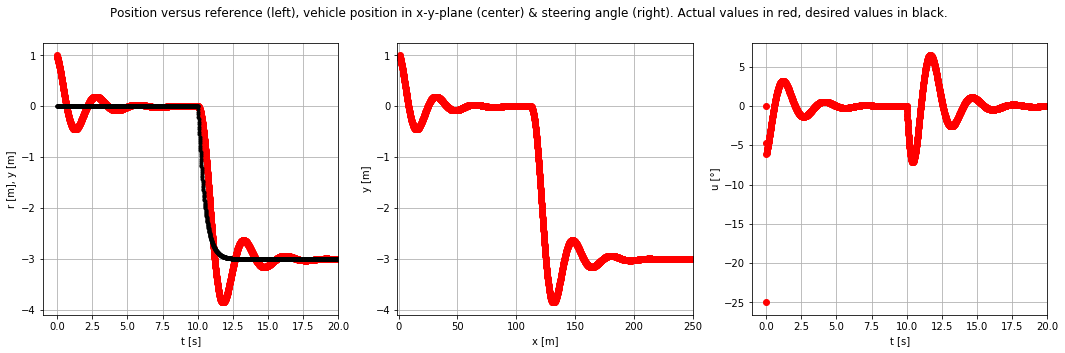

In [94]:
# create an instance of the bicycle model with vehicle paramters, initial position and heading
vehicle = Bicycle(v_l = 40 * 1000 / 3600, x0 = np.array([1.0,1.0, 0*np.pi/2]))
# set initial steering
vehicle.u = 0 * np.pi/ 180
# initial guess for kp, kd and ki
parameters = [0.12, 1.1, 0.000]
# run a simulation
x, y, u, r, t, objective = run_closed_loop_simulation(vehicle, parameters, n=10000)
# plot results and check
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18,5))
fig.subplots_adjust(hspace=10.0)
fig.suptitle('Position versus reference (left), vehicle position in x-y-plane (center) & steering angle (right). Actual values in red, desired values in black.')
ax0.plot(t, y, 'ro')
ax0.plot(t, r, 'k.')
ax0.set_xlim(-1, 20)
ax0.set_xlabel('t [s]')
ax0.set_ylabel('r [m], y [m]')
ax0.grid(True)
ax1.plot(x, y, 'ro')
ax1.set_xlim(-1, 250)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.grid(True)
ax2.plot(t, u, 'ro')
ax2.set_xlim(-1, 20)
ax2.set_xlabel('t [s]')
ax2.set_ylabel('u [°]')
ax2.grid(True)


For the set of controller paramters above, what can observed above is
- error dynamics are stable
- the controller output is within the limits [-25° 25°] that are for steering
Hence, these seem a good initial guess for the simulator as well. Before, an attempt is made to optimize them further using "twiddle".

## Numerical PID-Controller-Optimization
It can be cumbersome to tune the parameters of the PID-Control law manually. Hence, the "twiddle"-algorithm presented by Sebastian Thrun in Udacity's Self-Driving Car-Engineer Nanodegree Programm is invoked to find the opitmal set of parameters.

In [95]:
def twiddle(tol=0.1): 
    """
    This function implements the "twiddle"-algorithm presented by 
    Sebastian Thrun in Udacity's Self-Driving Car-Engineer Nanodegree Programm.
    It accepts the following parameter:
    tol, the tolerance with default value equal to 0.2.    
    """
    # limit number of iterations
    it_max = 50
    # initial guess for PID-parameters
    p = [0.12, 1.1, 0.000]
    # step-size for PID-Parameters
    dp = [0.1, 0.1, 0.0]
    # create an instance of the bicycle model with vehicle paramters, initial position and heading
    vehicle = Bicycle(v_l = 50 * 1000 / 3600, x0 = np.array([1.0,1.0, 0*np.pi/2]))
    # set initial steering
    vehicle.u = 0 * np.pi/ 180
    # run initial simulation
    x_trajectory, y_trajectory, u_trajectory, r_trajectory, t, best_err = run_closed_loop_simulation(vehicle, p, n=10000)
    it = 0
    print("Iteration | Objective obtained@parameter vector ")
    while (sum(dp) > tol):
        print(" {}        |  {} @ {}".format(it, best_err, p))
        for i in range(len(p)):
            p[i] += dp[i]
            # create an instance of the bicycle model with vehicle paramters, initial position and heading
            vehicle = Bicycle(v_l = 50 * 1000 / 3600, x0 = np.array([1.0,1.0, 0*np.pi/2]))
            # set initial steering
            vehicle.u = 0 * np.pi/ 180
            # run simulation
            x_trajectory, y_trajectory, u_trajectory, r_trajectory, t, err = run_closed_loop_simulation(vehicle, p, n=10000)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                # create an instance of the bicycle model with vehicle paramters, initial position and heading
                vehicle = Bicycle(v_l = 50 * 1000 / 3600, x0 = np.array([1.0,1.0, 0*np.pi/2]))
                # set initial steering
                vehicle.u = 0 * np.pi/ 180
                # run simulation
                x_trajectory, y_trajectory, u_trajectory, r_trajectory, t, err = run_closed_loop_simulation(vehicle, p, n=10000)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
        if it > it_max:
            break
    
    print("Twiddle has finished & returns parameters {}.".format(p))
    return p

Now we use "twiddle" to find an optimal set of parameters w.r.t. the lane change event and the bicylce-model instantiated with model parameters representing a Hyundai Azera (total wheel- base of 2.843 m, lf =1.105 m and lr = 1.738 m).

Iteration | Objective obtained@parameter vector 
 0        |  0.012663778572031922 @ [0.12, 1.1, 0.0]
 1        |  0.0061298121414264505 @ [0.22, 1.2000000000000002, 0.0]
 2        |  0.003674313366783768 @ [0.33, 1.3100000000000003, 0.0]
 3        |  0.0024824985512895315 @ [0.45100000000000007, 1.4310000000000003, 0.0]
 4        |  0.0018202027030105872 @ [0.5841000000000001, 1.2979000000000003, 0.0]
 5        |  0.0014497969243669735 @ [0.7305100000000001, 1.1514900000000001, 0.0]
 6        |  0.0012213593882476341 @ [0.8915610000000002, 0.9904390000000001, 0.0]
 7        |  0.0010714654216262042 @ [1.0687171000000002, 0.8132829000000001, 0.0]
 8        |  0.000969385326205372 @ [1.2635888100000003, 0.6184111900000001, 0.0]
 9        |  0.0008979480730898347 @ [1.4779476910000005, 0.404052309, 0.0]
 10        |  0.0008469530834936954 @ [1.7137424601000006, 0.1682575398999998, 0.0]
 11        |  0.000809933342637027 @ [1.9731167061100008, -0.09111670611000033, 0.0]
 12        |  0.00

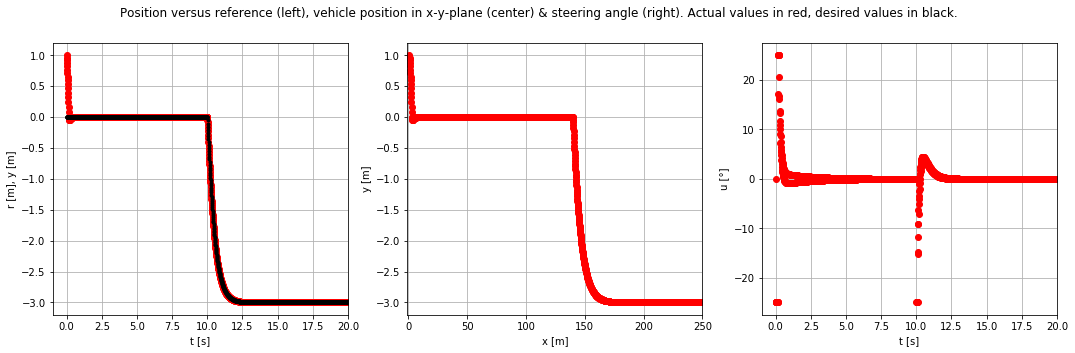

In [96]:
p = twiddle()
# create an instance of the bicycle model with vehicle paramters, initial position and heading
vehicle = Bicycle(v_l = 50 * 1000 / 3600, x0 = np.array([1.0,1.0, 0*np.pi/2]))
# set initial steering
vehicle.u = 0 * np.pi/ 180
# run simulation with optimal parameters
x, y, u, r, t, objective = run_closed_loop_simulation(vehicle, p, n=10000)
# plot results and check
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18,5))
fig.subplots_adjust(hspace=10.0)
fig.suptitle('Position versus reference (left), vehicle position in x-y-plane (center) & steering angle (right). Actual values in red, desired values in black.')
ax0.plot(t, y, 'ro')
ax0.plot(t, r, 'k.')
ax0.set_xlim(-1, 20)
ax0.set_xlabel('t [s]')
ax0.set_ylabel('r [m], y [m]')
ax0.grid(True)
ax1.plot(x, y, 'ro')
ax1.set_xlim(-1, 250)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.grid(True)
ax2.plot(t, u, 'ro')
ax2.set_xlim(-1, 20)
ax2.set_xlabel('t [s]')
ax2.set_ylabel('u [°]')
ax2.grid(True)

## Choice of controller parameters for the simulator
"twiddle" iterates the controller into a "large-gain" / bang-bang controller that utilizes the full control input range. This make sense since time-optimal control requires to utilize the full control input. However, this causes oszillations when applied to the real system.
Further optimization of the objective function inside "twiddle" is requested to favour softer control inputs.
The default paramters [0.12, 1.10, 0.00] are applied in the simulation enviroment provided by Udacity. 

## The effect of the P, I, D,-parameter components in the implementation.
The proportional gain "kp" reacts to the error directly. If the intention is to speed up the closed loop response, one should increase the proprtional gain. 

The differential gain contributes to the control law, when the error decreases or increases; it gives the controller a sense of "prediction" what it must do to prevent overshooting.

The integral gain reacts to persiting error caused by disturbances or parameter faults. If it is zero, a constant offset may remain in the error dynamics. Yet, care must be taken, when the to-be-controlled objects exhibts saturation in the control inputs: The controller may "wind up". Hence, in this project, the integral gain has been chosen to be euqal to zero.

## Concluding remarks
The controller tuning method presented here suffers from two issues:
- model uncertainty: The parameters l_r and l_f must be adjusted in order to represent Udacity's car better
- input saturation is not taken into account by "twiddle"
- large accelerations is not taken into account by "twiddle"

These points make it hard to pre-compute optimal control parameters using the model presented here. In the end, the inital guess [0.12, 1.10, 0.00] is used and found to be quite satisfying in the simulator. To further improve auto-tuning by twiddle a more elaborate objective function must be derived that penalizes jerks in vehicle motion and favours softer motion.